In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

In [89]:
def areas(box):
    return (box[2] - box[0]) * (box[3] - box[1])
def area(box):
    return (box[:,2] - box[:,0]) * (box[:,3] - box[:,1])
def al(box):
    return box[:,2] - box[:,0]    
def aw(box):
    return box[:,3] - box[:,1]
def intersection_over_union(boxes):
    assert(len(boxes) == 8)
    boxA = boxes[:4].values
    boxB = boxes[4:].values
    
    boxAArea = areas(boxA)
    boxBArea = areas(boxB)
    
    if (boxAArea == 0 or boxBArea == 0):
        return 0
        
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def weighted_averaging(data, item_id, np_data, avg):
    ix = data[(data['itemId'] == item_id) & (data['pxs_ratio'] > .5)].index
    vi = np_data[ix]
    l = np.fmax(al(vi), np.ones(len(vi), dtype=int))
    w = np.fmax(aw(vi), np.ones(len(vi), dtype=int))
    sabx = (l*w)**2
    sb = sum(1/sabx)
    for y in range(0,4):
        avg.loc[item_id][y] = sum(vi[:,y]/sabx)/sb
    avg.loc[item_id][4] = i  
    return avg.loc[item_id]

In [64]:
t_d = pd.read_csv('train_data.csv')
t_d['pxs'] = (t_d['Xmax'] - t_d['Xmin'])*(t_d['Ymax'] - t_d['Ymin'])
pxs = t_d.groupby("itemId")['pxs'].mean()
t_d = t_d.merge(pxs, on=["itemId"])
t_d['pxs_ratio'] = t_d['pxs_x'] / t_d['pxs_y']
t_a = pd.read_csv('train_answers.csv')
test_data = pd.read_csv('test_data.csv')

In [4]:
tdd = {}
tad = {}

tdcd = {}
tdvd = {}

tacd = {}
tavd = {}

tpd = {}
tad = {}

tdbd = {}
bxs = {}
codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY
]
itds = set(t_d['itemId'])
abx = np.array(t_d.loc[: 'itemId'][['Xmin','Ymin','Xmax','Ymax']])

In [7]:
quorum = pd.DataFrame(np.zeros((len(itds), 5), dtype=int), 
                      index=itds, columns=['Xmin','Ymin','Xmax','Ymax', 'itemId'])

In [70]:
obj = 8774
tdd[obj] = t_d[t_d['itemId'] == obj][['Xmin','Ymin','Xmin','Ymax','Xmax','Ymax','Xmax','Ymin','Xmin','Ymin', 'pxs_ratio']]
tdd[obj] = tdd[obj][tdd[obj]]
tad[obj] = t_a[t_a['itemId'] == obj][['Xmin_true','Ymin_true','Xmin_true','Ymax_true','Xmax_true','Ymax_true','Xmax_true','Ymin_true','Xmin_true','Ymin_true']]
tdbd[obj] = t_d[t_d['itemId'] == obj][['Xmin','Ymin','Xmax','Ymax']]

In [69]:
print()

    Xmin  Ymin  Xmin  Ymax  Xmax  Ymax  Xmax  Ymin  Xmin  Ymin  pxs_ratio
15   116   959   116  1300   795  1300   795   959   116   959   1.964226
16   308  1044   308  1317   755  1317   755  1044   308  1044   1.035231


In [26]:
for i in itds:
    weighted_averaging(t_d, i, abx, quorum)    

In [90]:
print(weighted_averaging(t_d, 8774, abx, quorum))

Xmin       266
Ymin      1025
Xmax       763
Ymax      1313
itemId       0
Name: 8774, dtype: int64


    Xmin  Ymin  Xmin  Ymax  Xmax  Ymax  Xmax  Ymin  Xmin  Ymin  pxs_ratio
15   116   959   116  1300   795  1300   795   959   116   959   1.964226
16   308  1044   308  1317   755  1317   755  1044   308  1044   1.035231
Xmin     266
Ymin    1025
Xmin     266
Ymax    1313
Xmax     763
Ymax    1313
Xmax     763
Ymin    1025
Xmin     266
Ymin    1025
Name: 8774, dtype: int64


(782, 1327.0)

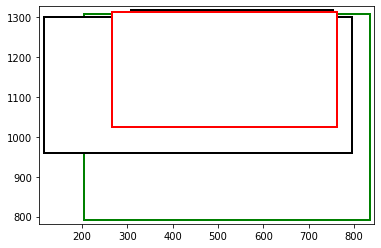

In [88]:
tdvd[obj] = []
tdcd[obj] = []
tacd[obj] = []
tavd[obj] = []

Xmin,Ymin = 2000, 2000
Xmax,Ymax = 0, 0
print(tdd[obj])
for i, r in tdd[obj].iterrows():    
    i = i - tdd[obj].index[0]
    for y in range(0,10,2):
        Xmin = min(Xmin, tdd[obj].iloc[i, y]) 
        Ymin = min(Ymin, tdd[obj].iloc[i, y + 1])
        Xmax = max(Xmax, tdd[obj].iloc[i, y]) 
        Ymax = max(Ymax, tdd[obj].iloc[i, y + 1])        
        tdvd[obj].append((tdd[obj].iloc[i, y], tdd[obj].iloc[i, y + 1]))
        tdcd[obj].append(codes[y//2])

i = 0  
tobj = tad[obj]
for y in range(0,10,2):
    Xmin = min(Xmin, tobj.iloc[i, y]) 
    Ymin = min(Ymin, tobj.iloc[i, y + 1])
    Xmax = max(Xmax, tobj.iloc[i, y]) 
    Ymax = max(Ymax, tobj.iloc[i, y + 1])            
    tavd[obj].append((tobj.iloc[i, y], tobj.iloc[i, y + 1]))
    tacd[obj].append(codes[y//2]) 

qobjc = []
qobjv = []
i = 0        
tobj = quorum.loc[obj][['Xmin','Ymin','Xmin','Ymax','Xmax','Ymax','Xmax','Ymin','Xmin','Ymin']]
print(tobj)
for y in range(0,10,2):
    Xmin = min(Xmin, tobj.iloc[y]) 
    Ymin = min(Ymin, tobj.iloc[y + 1])
    Xmax = max(Xmax, tobj.iloc[y]) 
    Ymax = max(Ymax, tobj.iloc[y + 1])            
    qobjv.append((tobj.iloc[y], tobj.iloc[y + 1]))
    qobjc.append(codes[y//2])     
    
fig, ax = plt.subplots()
ax.add_patch(patches.PathPatch(Path(tavd[obj], tacd[obj]), facecolor='white', edgecolor='green', lw=2))
ax.add_patch(patches.PathPatch(Path(tdvd[obj], tdcd[obj]), facecolor='white', edgecolor='black', lw=2))
ax.add_patch(patches.PathPatch(Path(qobjv, qobjc), facecolor='white', edgecolor='red', lw=2))

ax.set_xlim(Xmin - 10, Xmax + 10)
ax.set_ylim(Ymin - 10, Ymax + 10)    

In [325]:
data = quorum.merge(t_a, on=["itemId"])

In [330]:
data["iou"] = data[['Xmin','Ymin', 'Xmax', 'Ymax', 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

In [331]:
data["iou"].mean()
# вычислять райтинг пошльзоватлей

0.3761529565473004

In [334]:
users = set(t_d['userId'])
test_users = set(test_data['userId'])